In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rml2016/RML2016.10a_dict.pkl


In [2]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Path to the dataset
dataset_path = '/kaggle/input/rml2016/RML2016.10a_dict.pkl'

# Load the dataset using pickle
with open(dataset_path, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')

# Inspect the structure of the dataset
# Keys are tuples: (modulation type, SNR)
# Values are numpy arrays with I/Q data
print(f"Keys: {list(data.keys())[:5]}")  # Print first 5 keys to understand the structure
print(f"Shape of a sample: {data[list(data.keys())[0]].shape}")  # Shape of one I/Q sample array

# Prepare the data for training

# Get all modulation classes from the dataset
modulations = sorted(set([key[0] for key in data.keys()]))  # Extract all modulation types from the keys
print(f"Modulation Types: {modulations}")

# Initialize lists for input samples (X) and labels (y)
X = []
y = []

# Iterate over the dataset and extract I/Q data (X) and modulation labels (y)
for (modulation, snr), samples in data.items():
    # Append each sample to X and its corresponding modulation type to y
    X.extend(samples)  # 'samples' contains I/Q data for the current modulation/SNR pair
    y.extend([modulation] * len(samples))  # Same modulation label for all samples in this pair

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")  # (num_samples, 2, 128) expected
print(f"Shape of y: {y.shape}")  # (num_samples,)

# Reshape X to fit the model (for Conv2D input)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))  # Reshape to (num_samples, 2, 128, 1)

# Convert modulation labels (y) to integers for classification
modulation_to_idx = {modulation: idx for idx, modulation in enumerate(modulations)}
y_int = np.array([modulation_to_idx[mod] for mod in y])

# One-hot encode the labels for multi-class classification
y_onehot = to_categorical(y_int, num_classes=len(modulations))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# Output the shapes of the training and test sets
print(f"Training Data Shape: {X_train.shape}, Training Labels Shape: {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, Test Labels Shape: {y_test.shape}")


Keys: [('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8)]
Shape of a sample: (1000, 2, 128)
Modulation Types: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Shape of X: (220000, 2, 128)
Shape of y: (220000,)
Training Data Shape: (154000, 2, 128, 1), Training Labels Shape: (154000, 11)
Test Data Shape: (66000, 2, 128, 1), Test Labels Shape: (66000, 11)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Step 1: Define the model architecture based on the paper

def create_ofltamc_model(input_shape=(2, 128, 1), num_classes=11):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(filters=64, kernel_size=(2, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))  # Pooling only in the second dimension

    # Block 2
    model.add(layers.Conv2D(filters=128, kernel_size=(2, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))  # Pooling only in the second dimension

    # Block 3
    model.add(layers.Conv2D(filters=256, kernel_size=(2, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))  # Pooling only in the second dimension

    # Block 4
    model.add(layers.Conv2D(filters=512, kernel_size=(2, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))  # Pooling only in the second dimension

    # Block 5
    model.add(layers.Conv2D(filters=512, kernel_size=(2, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))  # Pooling only in the second dimension

    # Flatten
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(256, activation='relu'))

    # Fully Connected Layer 2
    model.add(layers.Dense(128, activation='relu'))

    # Output Layer (for classification into 11 modulation types)
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


# Step 2: Load and preprocess the dataset

# Path to the dataset
dataset_path = '/kaggle/input/rml2016/RML2016.10a_dict.pkl'

# Load the dataset using pickle
with open(dataset_path, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')

# Get the modulation types
modulations = sorted(set([key[0] for key in data.keys()]))

# Prepare input data (X) and labels (y)
X = []
y = []

for (modulation, snr), samples in data.items():
    X.extend(samples)
    y.extend([modulation] * len(samples))

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X to fit the model (add a depth dimension for CNN)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))  # Shape: (num_samples, 2, 128, 1)

# Convert modulation labels to integers for classification
modulation_to_idx = {modulation: idx for idx, modulation in enumerate(modulations)}
y_int = np.array([modulation_to_idx[mod] for mod in y])

# One-hot encode the labels
y_onehot = to_categorical(y_int, num_classes=len(modulations))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# Step 3: Create the model
input_shape = (2, 128, 1)  # I/Q data shape
num_classes = len(modulations)  # Number of modulation types
model = create_ofltamc_model(input_shape, num_classes)

# Step 4: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# Step 6: Visualize the accuracy and loss over epochs

def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

# Step 7: Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_13/1395233119.py", line 107, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_30221]

TPU not available, using default strategy.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Round 1/20
  Training on UAV 1


I0000 00:00:1731475568.745752     129 service.cc:145] XLA service 0x7dc7e8006f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731475568.745806     129 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731475572.467354     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Training on UAV 2
  Training on UAV 3
  Training on UAV 4
  Training on UAV 5
  Global Model - Loss: 2.9531, Accuracy: 0.0909
Round 2/20
  Training on UAV 1
  Training on UAV 2
  Training on UAV 3
  Training on UAV 4
  Training on UAV 5
  Global Model - Loss: 3.7013, Accuracy: 0.0909
Round 3/20
  Training on UAV 1
  Training on UAV 2
  Training on UAV 3
  Training on UAV 4
  Training on UAV 5
  Global Model - Loss: 2.3541, Accuracy: 0.1482
Round 4/20
  Training on UAV 1
  Training on UAV 2
  Training on UAV 3
  Training on UAV 4
  Training on UAV 5
  Global Model - Loss: 7.2547, Accuracy: 0.1185
Round 5/20
  Training on UAV 1
  Training on UAV 2
  Training on UAV 3
  Training on UAV 4
  Training on UAV 5
  Global Model - Loss: 30.0227, Accuracy: 0.1256
Round 6/20
  Training on UAV 1
  Training on UAV 2
  Training on UAV 3
  Training on UAV 4
  Training on UAV 5
  Global Model - Loss: 219.2683, Accuracy: 0.0859
Round 7/20
  Training on UAV 1
  Training on UAV 2
  Training on UAV 3
  T

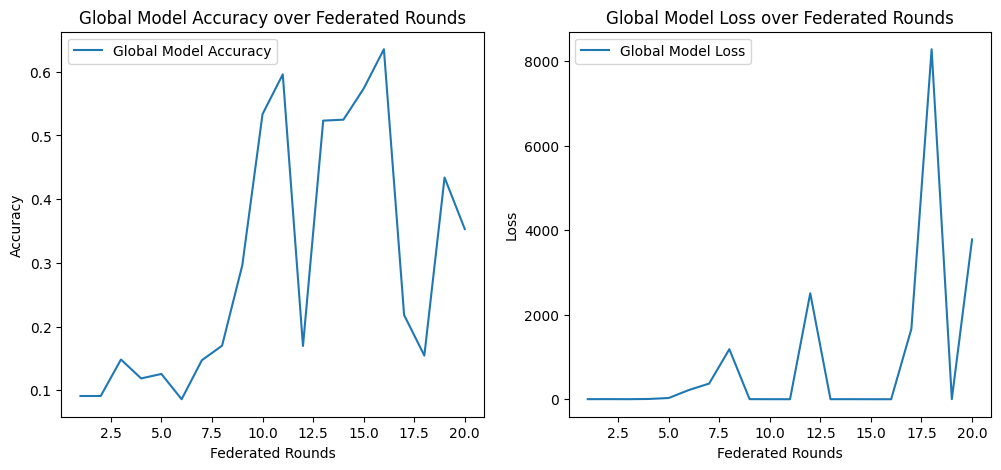

Final Global Model - Loss: 3782.0122, Accuracy: 0.3530


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

# Constants
NUM_UAVS = 5               # Number of UAVs
FEDERATED_ROUNDS = 20      # Number of federated training rounds
LOCAL_EPOCHS = 5           # Number of epochs each UAV trains locally
BATCH_SIZE = 32            # Fixed batch size

# Set up TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU initialized and strategy created.")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("TPU not available, using default strategy.")

# Model architecture
def create_model(input_shape=(2, 128, 1), num_classes=11):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (2, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Conv2D(128, (2, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Conv2D(256, (2, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Conv2D(512, (2, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Conv2D(512, (2, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Load dataset
dataset_path = '/kaggle/input/rml2016/RML2016.10a_dict.pkl'
with open(dataset_path, 'rb') as f:
    data = pickle.load(f,encoding = 'latin1')

# Prepare data
modulations = sorted(set([key[0] for key in data.keys()]))
X = []
y = []
for (modulation, snr), samples in data.items():
    X.extend(samples)
    y.extend([modulation] * len(samples))

X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
modulation_to_idx = {mod: idx for idx, mod in enumerate(modulations)}
y = np.array([modulation_to_idx[mod] for mod in y])
y = to_categorical(y, num_classes=len(modulations))

# Split data into UAVs
data_per_uav = len(X) // NUM_UAVS
uav_data = [(X[i * data_per_uav:(i + 1) * data_per_uav],
             y[i * data_per_uav:(i + 1) * data_per_uav]) for i in range(NUM_UAVS)]

# Federated Learning Process
with strategy.scope():
    global_model = create_model(input_shape=(2, 128, 1), num_classes=len(modulations))
    global_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])

def federated_average(weights_list):
    """Compute the average of weights from each UAV model to update the global model."""
    average_weights = []
    for weights in zip(*weights_list):
        average_weights.append(np.mean(weights, axis=0))
    return average_weights

# Track metrics for each federated round
global_accuracy = []
global_loss = []

# Federated Rounds
for round_num in range(FEDERATED_ROUNDS):
    print(f"Round {round_num + 1}/{FEDERATED_ROUNDS}")
    
    # Local training on each UAV
    local_weights = []
    for i, (local_X, local_y) in enumerate(uav_data):
        print(f"  Training on UAV {i + 1}")
        
        with strategy.scope():
            local_model = create_model(input_shape=(2, 128, 1), num_classes=len(modulations))
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            local_model.set_weights(global_model.get_weights())  # Initialize with global weights
            
            # Train the model locally
            local_model.fit(local_X, local_y, epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
            
            # Collect the trained weights
            local_weights.append(local_model.get_weights())
    
    # Aggregate local weights to update the global model
    new_weights = federated_average(local_weights)
    global_model.set_weights(new_weights)

    # Evaluate the global model on the entire dataset and track metrics
    loss, accuracy = global_model.evaluate(X, y, verbose=0)
    global_loss.append(loss)
    global_accuracy.append(accuracy)
    print(f"  Global Model - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Plotting the global accuracy and loss over federated rounds
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, FEDERATED_ROUNDS + 1), global_accuracy, label='Global Model Accuracy')
plt.title('Global Model Accuracy over Federated Rounds')
plt.xlabel('Federated Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, FEDERATED_ROUNDS + 1), global_loss, label='Global Model Loss')
plt.title('Global Model Loss over Federated Rounds')
plt.xlabel('Federated Rounds')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final Evaluation
final_loss, final_accuracy = global_model.evaluate(X, y, verbose=0)
print(f"Final Global Model - Loss: {final_loss:.4f}, Accuracy: {final_accuracy:.4f}")
